**概要**  
- LightGBM
- カテゴリカル変数の処理なし
- 欠損値処理
    - 量的変数・質的変数それぞれ一律で同じ値を代入
- 特徴量
    - 河原くんが調べた特徴量をいくつか追加
    - dri_scoreの大区分（頭についている要素抜き出し）を作成
        - SHAP値はそこそこ大きいので意味はありそうだが、精度はあまり変わってなさそう
    - さらに、High・Intermediate、Low等について順序尺度を導入
        - SHAP値は小さく、意味はあまりなさそう
        - 元のdri_scoreから情報を削っているから意味が薄れている？？
- ハイパーパラメータチューニング
    - 前回（lgbm_03）、Optunaで取得したパラメータを使用
    - 特徴量等が変わってるので意味あるのか？？

In [39]:
#csvファイルの読み込み
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import StratifiedKFold
import optuna
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [40]:
# INPUT_DIRにディレクトリを指定
INPUT_DIR = "xxx"
pd.set_option('display.max_columns', 500)

df_train = pd.read_csv(INPUT_DIR + "train.csv")
df_test = pd.read_csv(INPUT_DIR + "test.csv")
data_dic = pd.read_csv(INPUT_DIR + "data_dictionary.csv")# 辞書データ
sample_sub = pd.read_csv(INPUT_DIR + "sample_submission.csv")
df_train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


**過去の主要な処理を関数としてまとめる**

In [41]:
# 生存確率を計算する関数
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter() # インスタンスを作成
    kmf.fit(df[time_col], event_observed=df[event_col]) # カプラン・マイヤー推定量にデータをフィット
    survival_probabilities = kmf.survival_function_at_times(df[time_col]).values.flatten()
    censored_mask = df[event_col] == 0
    df["target"] = survival_probabilities

# 欠損値を一律で補完
def replace_nulls_with_uniform(df, float_default=0.0, object_default="Unknown"):
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = df[col].fillna(float_default)
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].fillna(object_default)
    return df

# object型をcategory型に変換
def convert_object_to_category(df):
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')
    return df

# 四則演算特徴量等を追加
def eda(df):
    df['age_karnofsky'] = df['age_at_hct'] * df['karnofsky_score']
    df['age_comorbidity'] = df['age_at_hct'] * df['comorbidity_score']
    df['donor_recipient_age_diff'] = abs(df['donor_age'] - df['age_at_hct'])
    df['years_since_2000'] = df['year_hct'] - 2000
    df['hla_match_ratio'] = (df['hla_high_res_8'] + df['hla_low_res_8']) / 16
    df['age_squared'] = df['age_at_hct'] ** 2
    df['karnofsky_squared'] = df['karnofsky_score'] ** 2
    
    # --- 1. 周期的な特徴量 ---
    # sin_year: サイン波
    df['sin_year'] = np.sin(df['year_hct'] * (2 * np.pi) / 100)
    
    # cos_year: コサイン波
    df['cos_year'] = np.cos(df['year_hct'] * (2 * np.pi) / 100)
    
    # --- 2. 年齢に基づく特徴量 ---
    # age_gap: 患者とドナーの年齢差（絶対値）
    df['age_gap'] = np.abs(df['age_at_hct'] - df['donor_age'])
    
    # diff_age_vs_donor: 患者の年齢 - ドナーの年齢
    df['diff_age_vs_donor'] = df['age_at_hct'] - df['donor_age']
    
    # --- 3. 技術進歩に基づく特徴量 ---
    # tech_progress: HCT実施年 - 最古のHCT実施年
    min_year_hct = df['year_hct'].min()
    df['tech_progress'] = df['year_hct'] - min_year_hct
    
    # --- 4. 性別に関する特徴量 ---
    # sex_one: 性別一致情報から患者の性別を抽出
    df['sex_one'] = df['sex_match'].str[0]  # 最初の文字を抽出
    
    # sex_two: 性別一致情報からドナーの性別を抽出
    df['sex_two'] = df['sex_match'].str[2]  # 3番目の文字を抽出
    
    # SameSex: 患者とドナーの性別が一致しているか
    df['SameSex'] = (df['sex_one'] == df['sex_two']).astype(int)

# カラムの削除
def drop_columns(df,columns):
    drop_cols = columns
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])
    return df


# 上記の関数による処理を行う
def overall_processing(df):
    # 欠損値処理
    df = replace_nulls_with_uniform(df, float_default=-1.0, object_default="Missing")

    # 特徴量の追加
    eda(df)

    # 生存確率の算出 
    if 'efs' in df.columns and 'efs_time' in df.columns:
        transform_survival_probability(df)    

    # 不要になったカラムを削除
    # df = drop_columns(df, ["ID", "efs", "efs_time"])

    # データ型をcategoryに変換
    df = convert_object_to_category(df)

    return df

In [42]:
df_train = overall_processing(df_train)
df_test = overall_processing(df_test)
df_train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,age_karnofsky,age_comorbidity,donor_recipient_age_diff,years_since_2000,hla_match_ratio,age_squared,karnofsky_squared,sin_year,cos_year,age_gap,diff_age_vs_donor,tech_progress,sex_one,sex_two,SameSex,target
0,0,N/A - non-malignant indication,No,Missing,No,-1.0,-1.0,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,-1.0,2.0,Missing,6.0,2.0,No,2.0,2.0,BM,Missing,Missing,Not Hispanic or Latino,2016,No,Missing,Yes,Missing,2.0,No,-1.00,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,Missing,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356,894.78,0.000,10.942,16,0.4375,98.843364,8100.0,0.844328,0.535827,10.942,10.942,8,M,F,0,0.458687
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672,3933.45,131.115,28.585,8,1.0000,1910.127025,8100.0,0.481754,0.876307,28.585,-28.585,0,F,F,1,0.847759
2,2,N/A - non-malignant indication,No,Missing,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Missing,Missing,Not Hispanic or Latino,2019,No,Missing,Yes,Missing,2.0,No,-1.00,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793,3059.73,0.000,34.997,19,1.0000,1155.796009,8100.0,0.929776,0.368125,34.997,34.997,11,F,M,0,0.462424
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349,3892.05,0.000,14.015,9,1.0000,1870.130025,8100.0,0.535827,0.844328,14.015,14.015,1,M,M,1,0.456661
4,4,High,No,Missing,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,Missing,5.0,2.0,No,2.0,2.0,PB,Missing,MAC,Hispanic or Latino,2018,No,Missing,Yes,Missing,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223,2676.60,29.740,27.070,18,1.0000,884.467600,8100.0,0.904827,0.425779,27.070,-27.070,10,M,F,0,0.464674


**カラム"dri_score"についてEDAを行う**

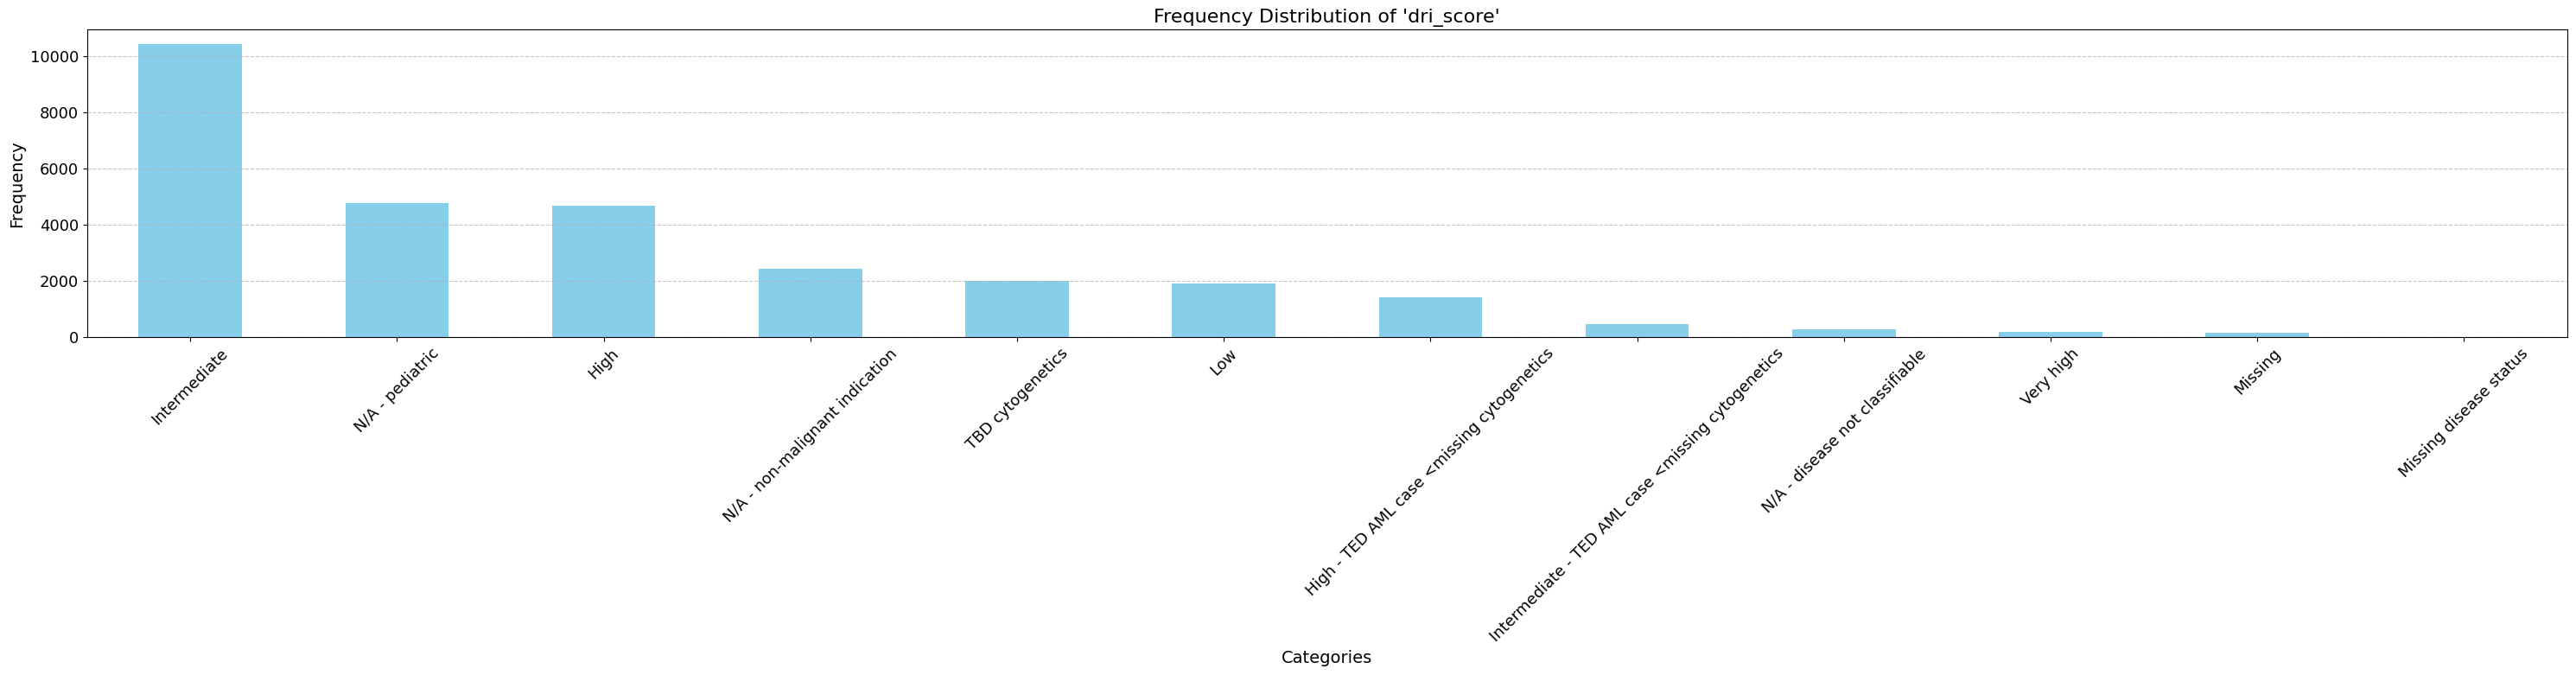

In [43]:
# カテゴリごとの頻度を把握
frequency_distribution = df_train['dri_score'].value_counts()

plt.rcParams['font.size'] = 13

# 棒グラフを描画
plt.figure(figsize=(30, 8))
frequency_distribution.plot(kind='bar', color='skyblue')
plt.title("Frequency Distribution of 'dri_score'", fontsize=16)
plt.xlabel("Categories", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

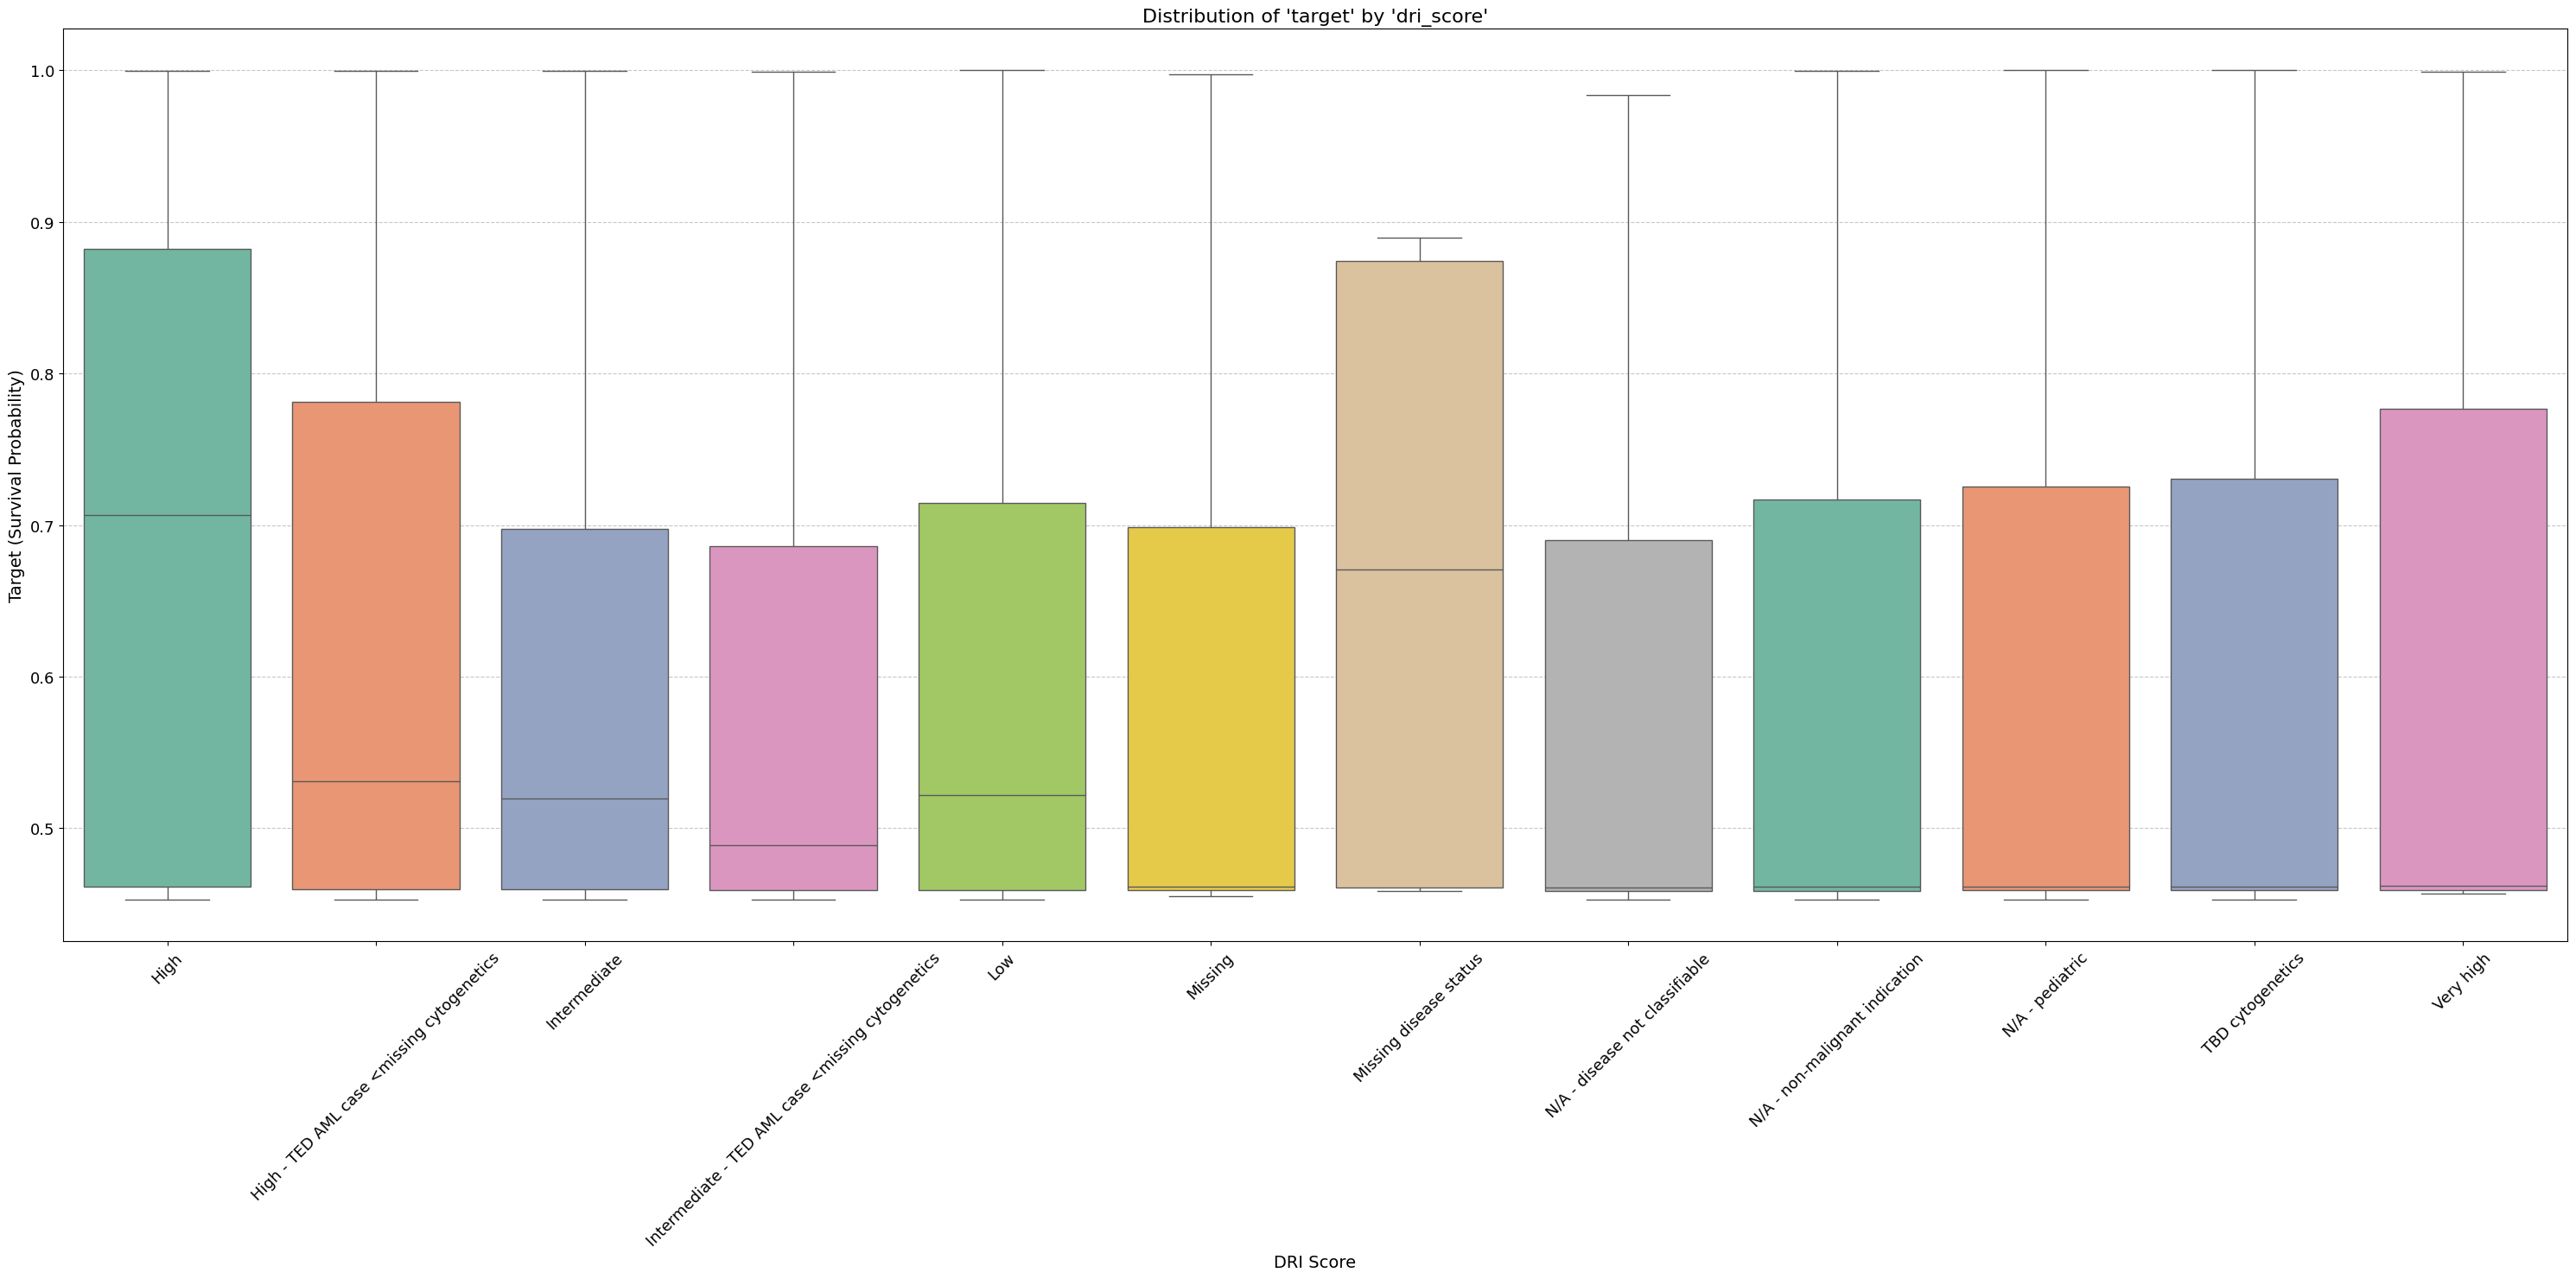

In [44]:
# dri_scoreと生存確率の関係性を確認
plt.rcParams['font.size'] = 13
plt.figure(figsize=(30, 15))
sns.boxplot(x='dri_score', y='target', data=df_train, palette='Set2')
plt.title("Distribution of 'target' by 'dri_score'", fontsize=16)
plt.xlabel("DRI Score", fontsize=14)
plt.ylabel("Target (Survival Probability)", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

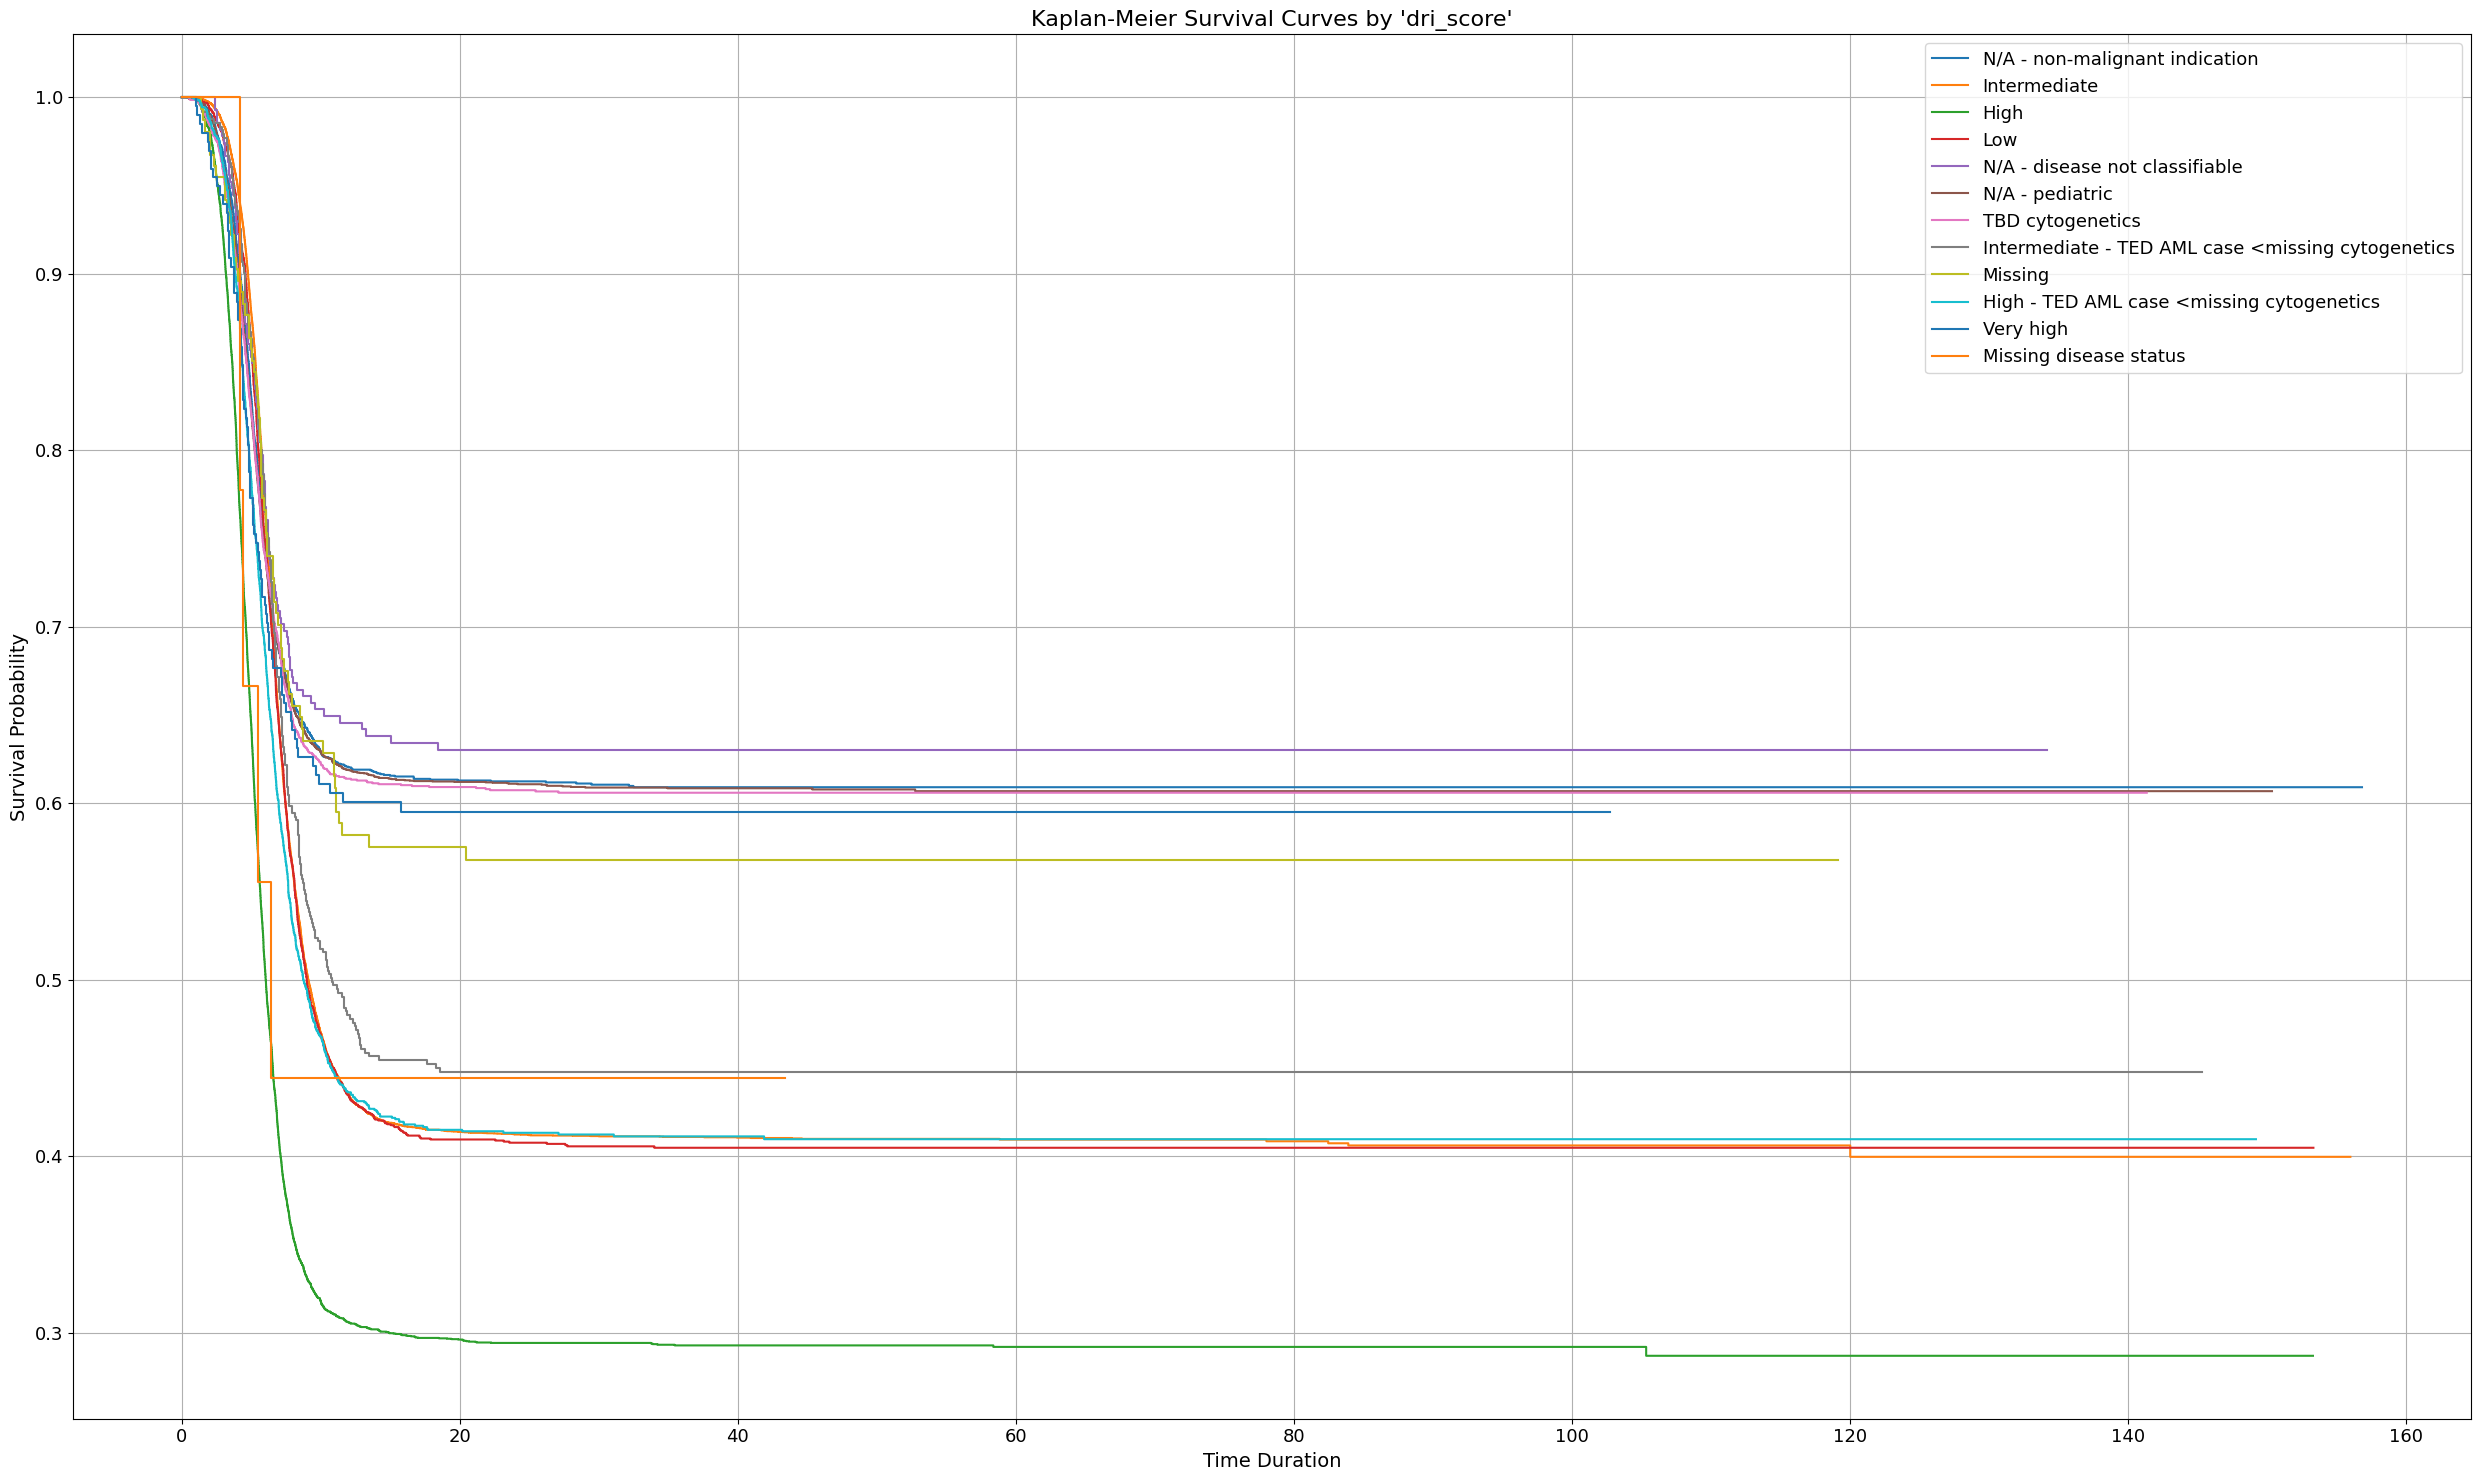

In [45]:
# dri_scoreごとの生存関数
required_columns = {'dri_score', 'efs_time', 'efs'}
# プロットの初期設定
plt.rcParams['font.size'] = 13
plt.figure(figsize=(25, 15))
kmf = KaplanMeierFitter()

# 'dri_score' の各カテゴリに対して生存曲線をプロット
for score in df_train['dri_score'].unique():
    mask = df_train['dri_score'] == score
    kmf.fit(durations=df_train[mask]['efs_time'], event_observed=df_train[mask]['efs'], label=f'{score}')
    kmf.plot_survival_function(ci_show=False)  # 信頼区間を非表示に設定

# グラフの装飾
plt.title("Kaplan-Meier Survival Curves by 'dri_score'", fontsize=16)
plt.xlabel("Time Duration", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

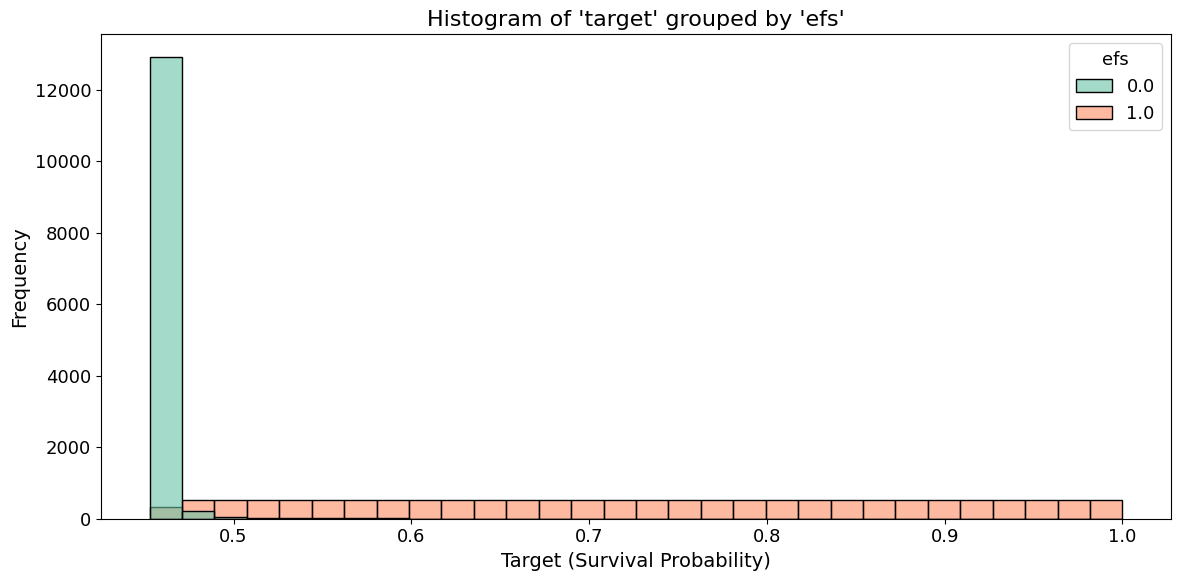

In [46]:
# ヒストグラムを描画
plt.figure(figsize=(12, 6))
sns.histplot(data=df_train, x='target', hue='efs', bins=30, palette='Set2', alpha=0.6)

# グラフの装飾
plt.title("Histogram of 'target' grouped by 'efs'", fontsize=16)
plt.xlabel("Target (Survival Probability)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()

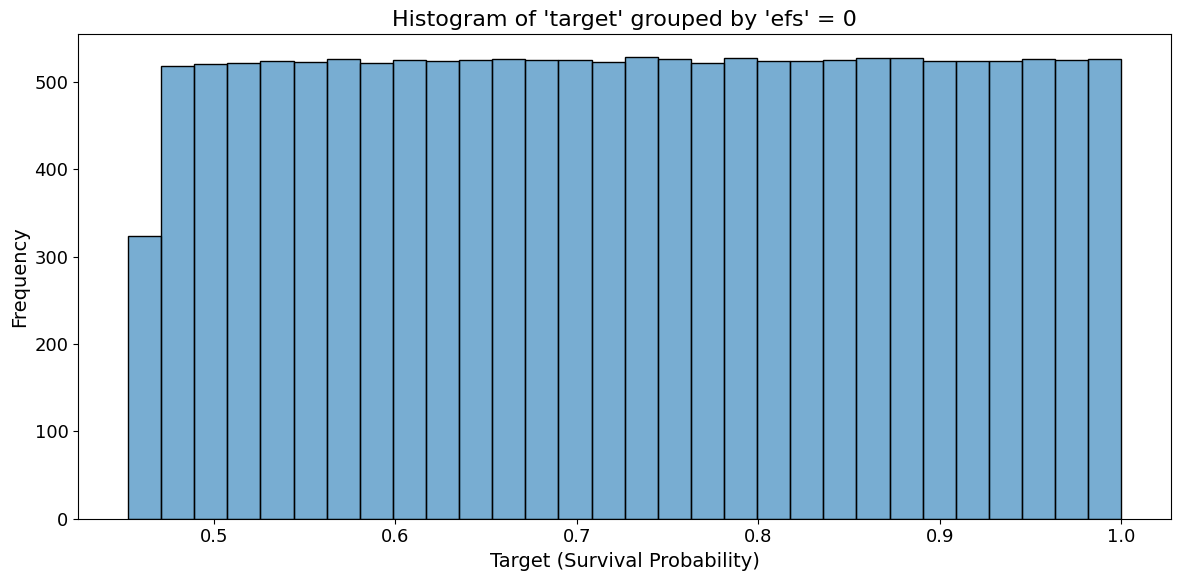

In [47]:
# ヒストグラムを描画
plt.figure(figsize=(12, 6))
sns.histplot(data=df_train[df_train["efs"] == 1], x='target', bins=30, palette='Set2', alpha=0.6)

# グラフの装飾
plt.title("Histogram of 'target' grouped by 'efs' = 0", fontsize=16)
plt.xlabel("Target (Survival Probability)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()

In [48]:
min(df_train["target"])

0.4527270342171866

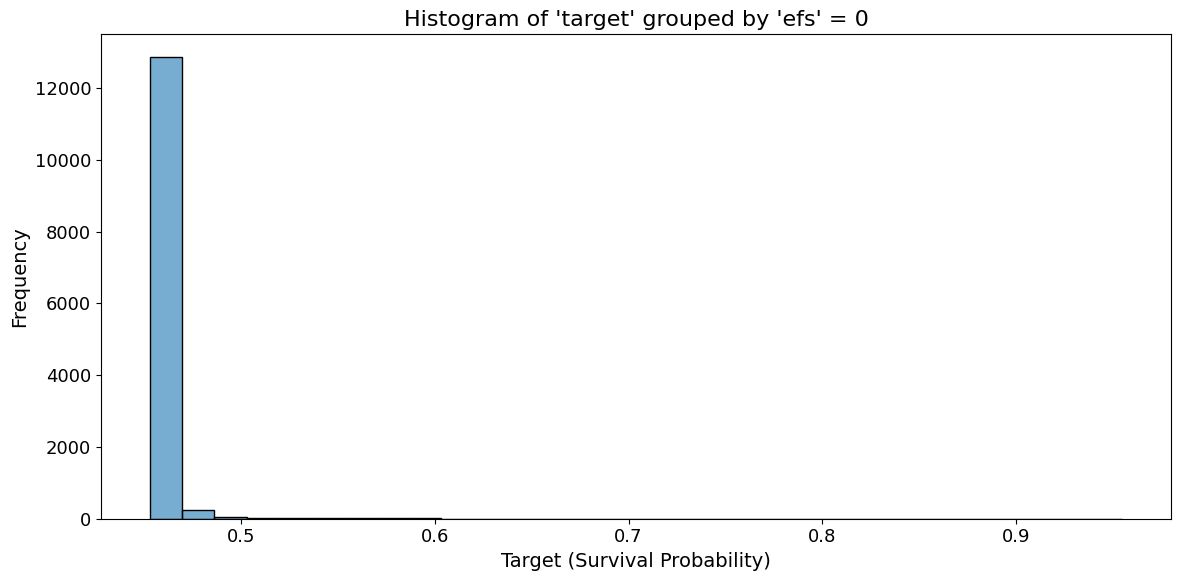

In [49]:
# ヒストグラムを描画
plt.figure(figsize=(12, 6))
sns.histplot(data=df_train[df_train["efs"] == 0], x='target', bins=30, palette='Set2', alpha=0.6)

# グラフの装飾
plt.title("Histogram of 'target' grouped by 'efs' = 0", fontsize=16)
plt.xlabel("Target (Survival Probability)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.tight_layout()
plt.show()

**カラムdri_scoreから新たな特徴量を生成する**

In [50]:
df_train["dri_score"].value_counts()

dri_score
Intermediate                                         10436
N/A - pediatric                                       4779
High                                                  4701
N/A - non-malignant indication                        2427
TBD cytogenetics                                      2003
Low                                                   1926
High - TED AML case <missing cytogenetics             1414
Intermediate - TED AML case <missing cytogenetics      481
N/A - disease not classifiable                         272
Very high                                              198
Missing                                                154
Missing disease status                                   9
Name: count, dtype: int64

**dri_scoreの程度の情報のみを抜き出して新しい特徴量にする**

In [51]:
# カテゴリごとの条件を指定
categories = {
    'high': ['high'],
    'very_high': ['very high'],
    'low': ['low'],
    'intermediate': ['intermediate'],
    'tbd': ['tbd'],
    'missing': ['missing'],
    'n/a': ['n/a']
}

# 小文字に変換し、各カテゴリにマッチするかどうかを判定（文字列の先頭を確認するバージョン）
def categorize_dri_score(value):
    if pd.isna(value):  # 欠損値チェック
        return 'missing'
    value = value.lower()  # 小文字に変換
    for category, keywords in categories.items():
        for keyword in keywords:
            if value.startswith(keyword):  # 頭に該当文字列が含まれるか確認
                return category
    return 'other'  # 該当しない場合は'other'

# 新しいカラムを追加して分類結果を保存
def add_categorize_dri_score(df):
    df['dri_score_category'] = df['dri_score'].apply(categorize_dri_score)
    return df

In [52]:
df_train = add_categorize_dri_score(df_train)
df_train["dri_score_category"].value_counts()

dri_score_category
intermediate    10917
n/a              7478
high             6115
tbd              2003
low              1926
very_high         198
missing           163
Name: count, dtype: int64

In [53]:
df_test = add_categorize_dri_score(df_test)
df_test["dri_score_category"].value_counts()

dri_score_category
n/a             2
intermediate    1
Name: count, dtype: int64

In [54]:
# 順序尺度を導入
def convert_to_ordinal(score):
    if score == 'very_high':
        return 4
    elif score == 'high':
        return 3
    elif score == 'intermediate':
        return 2
    elif score == 'low':
        return 1
    else:
        return 0

def add_categorize_dri_score_order(df):
    # 新しいカラムを追加
    df['dri_score_order'] = df['dri_score_category'].apply(convert_to_ordinal)
    return df

In [55]:
df_train = add_categorize_dri_score_order(df_train)
df_test = add_categorize_dri_score_order(df_test)
df_train["dri_score_order"].value_counts()

dri_score_order
2    10917
0     9644
3     6115
1     1926
4      198
Name: count, dtype: int64

In [56]:
df_train = convert_object_to_category(df_train)
df_test = convert_object_to_category(df_test)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 78 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   ID                        28800 non-null  int64   
 1   dri_score                 28800 non-null  category
 2   psych_disturb             28800 non-null  category
 3   cyto_score                28800 non-null  category
 4   diabetes                  28800 non-null  category
 5   hla_match_c_high          28800 non-null  float64 
 6   hla_high_res_8            28800 non-null  float64 
 7   tbi_status                28800 non-null  category
 8   arrhythmia                28800 non-null  category
 9   hla_low_res_6             28800 non-null  float64 
 10  graft_type                28800 non-null  category
 11  vent_hist                 28800 non-null  category
 12  renal_issue               28800 non-null  category
 13  pulm_severe               28800 non-null  cate

In [57]:
df_train = drop_columns(df_train, ["ID", "efs", "efs_time"])
df_test = drop_columns(df_test, ["ID", "efs", "efs_time"])
df_train.head()

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,age_karnofsky,age_comorbidity,donor_recipient_age_diff,years_since_2000,hla_match_ratio,age_squared,karnofsky_squared,sin_year,cos_year,age_gap,diff_age_vs_donor,tech_progress,sex_one,sex_two,SameSex,target,dri_score_category,dri_score_order
0,N/A - non-malignant indication,No,Missing,No,-1.0,-1.0,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,-1.0,2.0,Missing,6.0,2.0,No,2.0,2.0,BM,Missing,Missing,Not Hispanic or Latino,2016,No,Missing,Yes,Missing,2.0,No,-1.00,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,Missing,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,894.78,0.000,10.942,16,0.4375,98.843364,8100.0,0.844328,0.535827,10.942,10.942,8,M,F,0,0.458687,n/a,0
1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,3933.45,131.115,28.585,8,1.0000,1910.127025,8100.0,0.481754,0.876307,28.585,-28.585,0,F,F,1,0.847759,intermediate,2
2,N/A - non-malignant indication,No,Missing,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Missing,Missing,Not Hispanic or Latino,2019,No,Missing,Yes,Missing,2.0,No,-1.00,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,3059.73,0.000,34.997,19,1.0000,1155.796009,8100.0,0.929776,0.368125,34.997,34.997,11,F,M,0,0.462424,n/a,0
3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,3892.05,0.000,14.015,9,1.0000,1870.130025,8100.0,0.535827,0.844328,14.015,14.015,1,M,M,1,0.456661,high,3
4,High,No,Missing,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,Missing,5.0,2.0,No,2.0,2.0,PB,Missing,MAC,Hispanic or Latino,2018,No,Missing,Yes,Missing,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,2676.60,29.740,27.070,18,1.0000,884.467600,8100.0,0.904827,0.425779,27.070,-27.070,10,M,F,0,0.464674,high,3


In [58]:
# データの準備
X = df_train.drop(columns=['target'], axis=1)
y = df_train['target']
race_groups = df_train['race_group']  # 層別に利用

**モデル構築**

In [59]:
# Stratified C-indexの算出
def stratified_c_index(y_true, y_pred, groups):
    unique_groups = np.unique(groups)
    c_indices = []

    for group in unique_groups:
        mask = groups == group
        if sum(mask) > 1:  
            y_true_group = y_true[mask]
            y_pred_group = y_pred[mask]
            concordant = 0
            permissible = 0

            for i in range(len(y_true_group)):
                for j in range(i + 1, len(y_true_group)):
                    if y_true_group[i] != y_true_group[j]:
                        permissible += 1
                        if (y_pred_group[i] > y_pred_group[j] and y_true_group[i] > y_true_group[j]) or \
                           (y_pred_group[i] < y_pred_group[j] and y_true_group[i] < y_true_group[j]):
                            concordant += 1

            c_indices.append(concordant / permissible if permissible > 0 else 0)

    c_indices = np.array(c_indices)
    return np.mean(c_indices) - np.std(c_indices)

In [60]:
# カテゴリカル変数の列を取得
cat_features = list(X.select_dtypes(include=['category']).columns)

In [63]:
# K分割交差検証
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_predictions = np.zeros(len(X))

for fold, (train_idx, val_idx) in enumerate(kf.split(X, race_groups)):
    print(f"Fold {fold + 1}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    race_val = race_groups.iloc[val_idx]

    # LightGBM用データセット作成
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features)

    # 使用するチューニング対象外のパラメータ
    best_params = {
        'objective': 'regression',  # 最小化させるべき損失関数
        'metric': 'rmse',  # 学習時に使用する評価指標(early_stoppingの評価指標にも同じ値が使用される)
        'random_state': 42,  # 乱数シード
        'boosting_type': 'gbdt',
        'n_estimators': 10000,  # 最大学習サイクル数。early_stopping使用時は大きな値を入力
        'verbose': -1,  # これを指定しないと`No further splits with positive gain, best gain: -inf`というWarningが表示される
        'early_stopping_round': 10,  # ここでearly_stoppingを指定
        'reg_alpha': 0.030625843012809087, 
        'reg_lambda': 0.00017600143797012052, 
        'num_leaves': 3, 
        'colsample_bytree': 0.4238321137256774, 
        'subsample': 0.738201254772324, 
        'subsample_freq': 6, 
        'min_child_samples': 7        
        }

    # モデルの訓練
    model = lgb.train(
        best_params, # Optunaで得たハイパーパラメータ
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        # early_stopping_rounds=50, # 検証スコアが改善されないラウンド数
        callbacks=[lgb.early_stopping(stopping_rounds=50)],  # コールバックで早期終了を設定（early_stopping_roundだとエラーが出たため）
        # verbose_eval=100, # 100回ごとに学習結果を表示
        num_boost_round=1000, # 学習ラウンド数
    )

    # 予測と評価
    y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    fold_score = stratified_c_index(y_val.values, y_val_pred, race_val.values) # Stratified C統計量の確認
    print(f"Stratified C-Index for Fold {fold + 1}: {fold_score}")

    final_predictions[val_idx] = y_val_pred

# 全体での評価スコア
overall_score = stratified_c_index(y.values, final_predictions, race_groups.values)
print(f"Overall Score: {overall_score}")

Fold 1
Training until validation scores don't improve for 50 rounds
Stratified C-Index for Fold 1: 0.6357150159032865
Fold 2
Training until validation scores don't improve for 50 rounds
Stratified C-Index for Fold 2: 0.6291167305546278
Fold 3
Training until validation scores don't improve for 50 rounds
Stratified C-Index for Fold 3: 0.6337834410506137
Fold 4
Training until validation scores don't improve for 50 rounds
Stratified C-Index for Fold 4: 0.6209956565404934
Fold 5
Training until validation scores don't improve for 50 rounds
Stratified C-Index for Fold 5: 0.63613326314911
Overall Score: 0.633969001807819


In [25]:
#notebook内でJavascriptを動かすためのおまじない
import shap
shap.initjs()
#TreeExplainerは、決定木系のモデルのSHAP値を取得するもの。
explainer = shap.TreeExplainer(model=model)

print(explainer.expected_value) #なんで出力されない？？

None


In [27]:
X_val_shap = X_val.copy().reset_index(drop=True)
shap_values = explainer.shap_values(X=X_val_shap)

print(X_val_shap.shape)
print(shap_values.shape)
print(shap_values[0])#テストデータの0番目の要素における，各特徴量のSHAP値（貢献スコア）

(5760, 73)
(5760, 73)
[ 4.06127891e-02 -9.55280421e-04 -1.53246982e-03 -2.67455701e-03
 -4.76673486e-04  0.00000000e+00 -3.84504218e-03 -1.92537798e-03
  9.64535800e-04  9.01063323e-04 -3.51100738e-04  2.49650132e-05
 -2.49657976e-03 -1.94114084e-03 -7.29756724e-04  1.14663224e-03
  0.00000000e+00 -2.59421894e-05  4.44807874e-03  7.87878746e-04
 -1.81738990e-04 -1.82630163e-05  1.17876622e-05 -2.61552633e-05
  1.21293362e-04 -9.50862625e-03  3.85338160e-03  0.00000000e+00
  1.99404851e-03 -4.52435496e-04  1.04849324e-02  1.55976910e-03
 -3.74769836e-04 -6.04303817e-03  6.05907124e-04  2.55644494e-03
  1.70528176e-03  5.02300473e-04  2.45011907e-04  1.62592686e-04
 -1.90965922e-03 -6.11417828e-03  1.77287237e-04  4.66616181e-03
 -2.23437765e-04 -3.83580270e-03 -7.63276097e-03 -8.31096404e-03
 -4.29910559e-04 -2.12065476e-03 -8.03110412e-03 -1.58434488e-03
  4.14075104e-04 -9.73078555e-04  1.27202398e-03  1.59113098e-05
  1.35658611e-05  9.86749002e-04 -4.70554059e-03  3.36351170e-04
  2

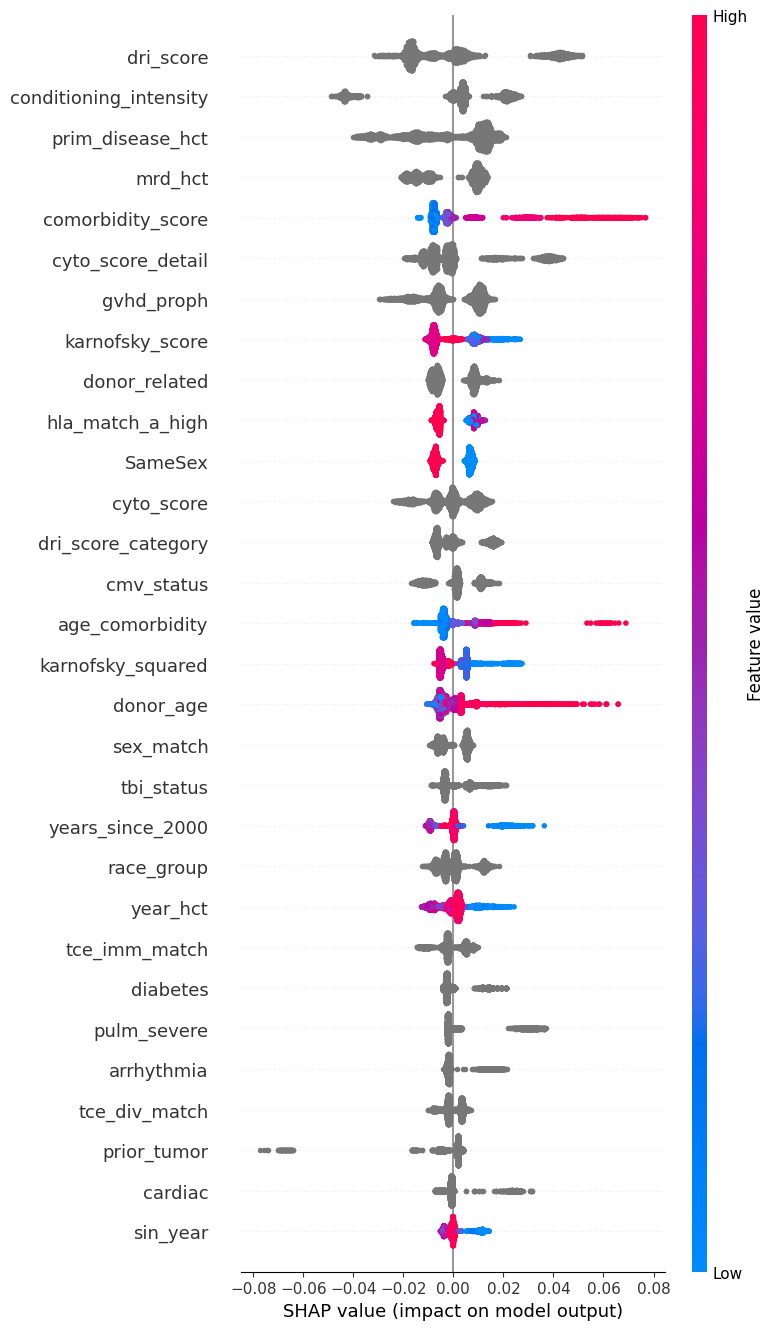

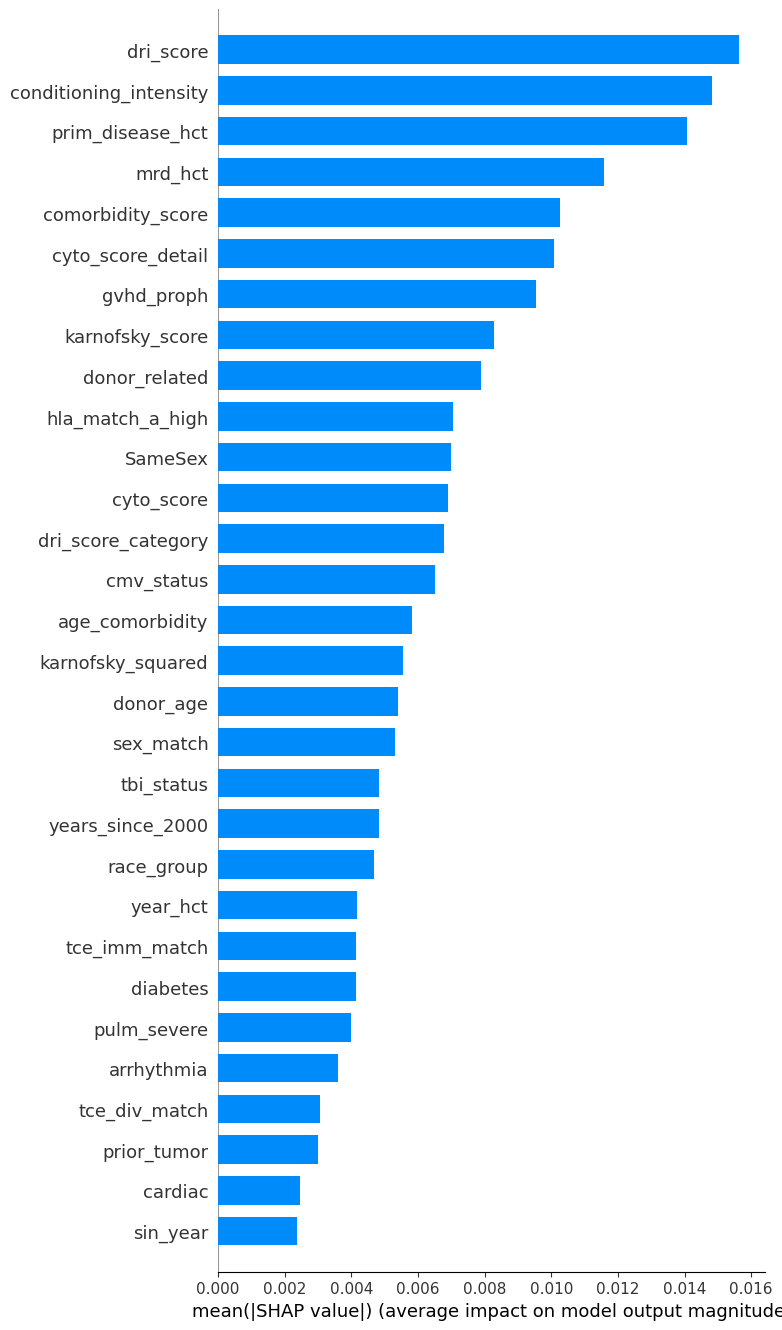

In [65]:
# 可視化
shap.summary_plot(shap_values, X_val_shap, max_display=30) #左側の図
# プロットの描画
plt.figure()  # 新しい図を作成
shap.summary_plot(shap_values, X_val_shap, plot_type='bar', max_display=30, show=False) 
plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches='tight')  # 保存
plt.show()
plt.close()  # プロットを閉じる